In [1]:
# Plots for basecalling accuracy with lossy compression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd

In [5]:
compressed_size_dir = '../../../data/NA12878/compressed_size_summary/'
NUM_EXP = 10 # we tried maxerror parameter from 1 to 10

In [6]:
# load compressed sizes and signal lengths into numpy arrays
# array size = number of reads

with open(compressed_size_dir+'/VBZ_lossless.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = [row for row in reader]
    
signal_lengths = np.array([int(row[1]) for row in rows[1:]],dtype=int)
lossless_sizes = np.array([int(row[2]) for row in rows[1:]],dtype=int)

LFZip_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)
SZ_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)

for i in range(NUM_EXP):
    with open(compressed_size_dir+'/LFZip_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    LFZip_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    
for i in range(NUM_EXP):
    with open(compressed_size_dir+'/SZ_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    SZ_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    

In [7]:
# compute some totals 
signal_lengths_sum = np.sum(signal_lengths)
lossless_sizes_sum = np.sum(lossless_sizes)
LFZip_sizes_sum = np.sum(LFZip_sizes,axis=1)
SZ_sizes_sum = np.sum(SZ_sizes,axis=1)

In [8]:
# Average compression ratio (bytes/signal value) for lossless compression
print('Lossless compression ratio:','{:.3f}'.format((lossless_sizes_sum/signal_lengths_sum)))

Lossless compression ratio: 0.813


In [9]:
# Now load the methylation data

methylation_data_file = '../../../data/NA12878/methylation_evaluation_summary.tsv'

precision = {'lossless':None,'LFZip':None,'SZ':None}
recall = {'lossless':None,'LFZip':None,'SZ':None}
auc = {'lossless':None,'LFZip':None,'SZ':None}

with open(methylation_data_file) as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = [row for row in reader]

data_dict = {}
for row in rows[1:]:
    data_dict[row[0]] = row[1:]

precision['lossless'] = float(data_dict['lossless'][6])
recall['lossless'] = float(data_dict['lossless'][7])
auc['lossless'] = float(data_dict['lossless'][8])

for compressor in ['LFZip','SZ']:
    precision[compressor] = np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)][6]) \
                                for i in range(NUM_EXP)])
    recall[compressor] = np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)][7]) \
                                for i in range(NUM_EXP)])
    auc[compressor] = np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)][8]) \
                                for i in range(NUM_EXP)])

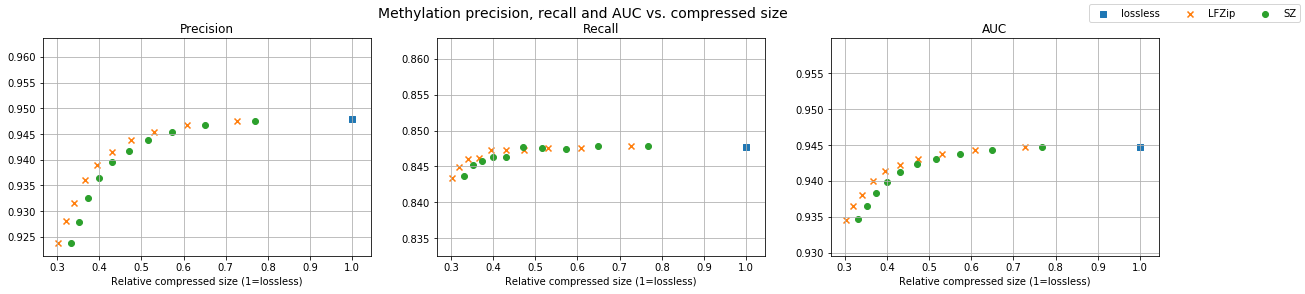

In [15]:
marker = {'LFZip': 'x', 'SZ': 'o'}
legend = ['lossless','LFZip','SZ']

fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,4))
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}

for ax_ in ax.flatten():
    ax_.set_xticks(np.arange(0.2,1.05,0.1))
    ax_.set_xlabel('Relative compressed size (1=lossless)')
    
# scatter plots
ax[0].scatter(1.0,precision['lossless'],marker='s')
for compressor in ['LFZip','SZ']:
    ax[0].scatter(compressed_sizes[compressor],\
                    precision[compressor],\
                    marker=marker[compressor])
ax[0].grid()
ax[0].set_title('Precision') 


ax[1].scatter(1.0,recall['lossless'],marker='s')
for compressor in ['LFZip','SZ']:
    ax[1].scatter(compressed_sizes[compressor],\
                    recall[compressor],\
                    marker=marker[compressor])
ax[1].grid()
ax[1].set_title('Recall') 


ax[2].scatter(1.0,auc['lossless'],marker='s')
for compressor in ['LFZip','SZ']:
    ax[2].scatter(compressed_sizes[compressor],\
                    auc[compressor],\
                    marker=marker[compressor])
ax[2].grid()
ax[2].set_title('AUC') 

fig.legend(legend,ncol=3)#, bbox_to_anchor=(0.4,0.0), ncol=3, loc="lower center")
fig.suptitle('Methylation precision, recall and AUC vs. compressed size',y=0.99,fontsize=14)

plt.savefig('methylation.pdf',bbox_inches='tight')
